In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.model_selection import cross_val_predict,cross_val_score,train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,auc, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score, f1_score
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns

In [2]:
ticketdata=pd.read_csv('~/Telus/painterview_ticketdata.csv')
resolutioncode=pd.read_csv('~/Telus/painterview_resolutioncodes.csv')
survey=pd.read_csv('~/Telus/painterview_customersurvey.csv')

In [43]:
print((survey[['TICKET_NUMBER','SURVEY_ID']].groupby('TICKET_NUMBER').count()).reset_index().groupby('SURVEY_ID').count())

# 29 tickets have multiple surveys, without knowing the reason why multiple surveys assoicated to the same ticket,
# the next step before merging files is to make sure only one rating associated to each ticket_number
# I choose taking the average score for the ratings to each ticket

survey_avged=survey[['TICKET_NUMBER', 'Customer Experience Score']].groupby('TICKET_NUMBER').mean().reset_index()
survey_avged.info()

           TICKET_NUMBER
SURVEY_ID               
1                   9760
2                      9
5                     20
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9789 entries, 0 to 9788
Data columns (total 2 columns):
TICKET_NUMBER                9789 non-null int64
Customer Experience Score    9789 non-null int64
dtypes: int64(2)
memory usage: 153.0 KB


In [7]:
# Merge ticket, survey, and solutioncode files:
ticket_survey=pd.merge(ticketdata, survey_avged, how='left', left_on='Ticket Number', right_on='TICKET_NUMBER')
Combined=pd.merge(ticket_survey, resolutioncode, how='left', left_on='RESOLUTION_CODE', right_on=' Resolution Code')
Combined.drop(['TICKET_NUMBER',' Resolution Code'], axis=1, inplace=True)

print(Combined.info())

# Replace missing value:
Combined.loc[Combined['Customer SEGMENT'].isnull(),'Customer SEGMENT']='Unknown'
Combined.loc[Combined['City'].isnull(),'City']='Unknown'
Combined.loc[Combined['Province'].isnull(),'Province']='Unknown'
Combined.loc[Combined['Condition'].isnull(),'Condition']='Unknown'
Combined.loc[Combined['Dispatch Tier'].isnull(),'Dispatch Tier']='Unknown'
Combined.loc[Combined['RESOLUTION_CODE'].isnull(),'RESOLUTION_CODE']='Unknown'
Combined.loc[Combined['Resolution Reason'].isnull(),'Resolution Reason']='Unknown'
Combined.loc[Combined['Customer Experience Score'].isnull(),'Customer Experience Score']=0

# New Metric and formatting:
Combined['Time To Restore (Hrs)']=Combined['Time To Restore (Hrs)'].astype(int)
Combined['Customer Experience Score']=Combined['Customer Experience Score'].astype(int)
Combined.loc[Combined['Time To Restore (Hrs)']>24 ,'Service Target Met']='Not Met'
Combined.loc[Combined['Time To Restore (Hrs)']<=24 ,'Service Target Met']='Met'
Combined.loc[Combined['Customer Experience Score'].isin([1,2]) ,'Experience']='Poor'
Combined.loc[Combined['Customer Experience Score'].isin([4,5]) ,'Experience']='Good'

print(Combined.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158097 entries, 0 to 158096
Data columns (total 17 columns):
Line Of Business             158097 non-null object
Customer SEGMENT             146819 non-null object
Ticket Number                158097 non-null int64
Ticket Create Date           158097 non-null object
Ticket Create Time           158097 non-null object
Ticket Closed Date           158097 non-null object
Ticket Closed Time           158097 non-null object
Ticket Resolution Date       158097 non-null object
Ticket Resolution Time       158097 non-null object
City                         157203 non-null object
Province                     157921 non-null object
Condition                    158086 non-null object
Time To Restore (Hrs)        158097 non-null float64
Dispatch Tier                156992 non-null float64
RESOLUTION_CODE              157778 non-null object
Customer Experience Score    7656 non-null float64
Resolution Reason            157778 non-null object
dtype

### Categorical Feature Examination and Binning:

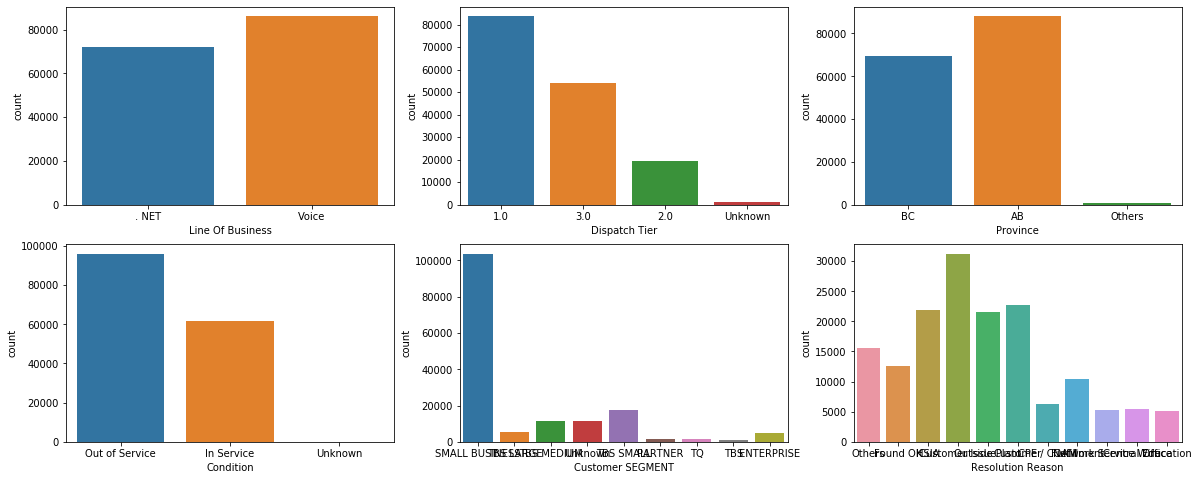

In [85]:
# Examine on the categorical variables
fig, axs = plt.subplots(nrows=2,ncols=3, figsize=(20,8))
ax1 = sns.countplot(x="Line Of Business", data=Combined,ax=axs[0,0])
ax2= sns.countplot(x="Customer SEGMENT", data=Combined, ax=axs[1,1])
ax3 = sns.countplot(x="Province", data=Combined, ax=axs[0,2])
ax4 = sns.countplot(x="Condition", data=Combined, ax=axs[1,0])
ax5 = sns.countplot(x="Dispatch Tier", data=Combined, ax=axs[0,1])
ax6 = sns.countplot(x="Resolution Reason", data=Combined, ax=axs[1,2])


In [9]:
# Group categories: - Province and Resolution Reason need some grouping on categories with small counts
# top 10 Resolution Reason
ResolutionReason_Top10=Combined.groupby('Resolution Reason')[['Ticket Number']].count().sort_values(by=['Ticket Number'], ascending=False).reset_index().head(10)
print(ResolutionReason_Top10)

Combined.loc[Combined['Resolution Reason'].isin(ResolutionReason_Top10['Resolution Reason']), 'Resolution Reason']=Combined['Resolution Reason']
Combined.loc[~Combined['Resolution Reason'].isin(ResolutionReason_Top10['Resolution Reason']), 'Resolution Reason']='Others'
Combined.loc[~Combined['Resolution Reason'].isin(ResolutionReason_Top10['Resolution Reason']), 'Resolution Reason']='Others'
Combined.loc[~Combined['Province'].isin(['AB','BC']), 'Province']='Others'

      Resolution Reason  Ticket Number
0        Customer Issue          31272
1              Customer          22689
2                  HSIA          21928
3         Outside Plant          21509
4              Found OK          12550
5           Fulfillment          10479
6            CPE / COAM           6204
7        Central Office           5376
8  Network Service Wire           5273
9             Education           5192


### Service Target Performance under Each Category: (All tickets)

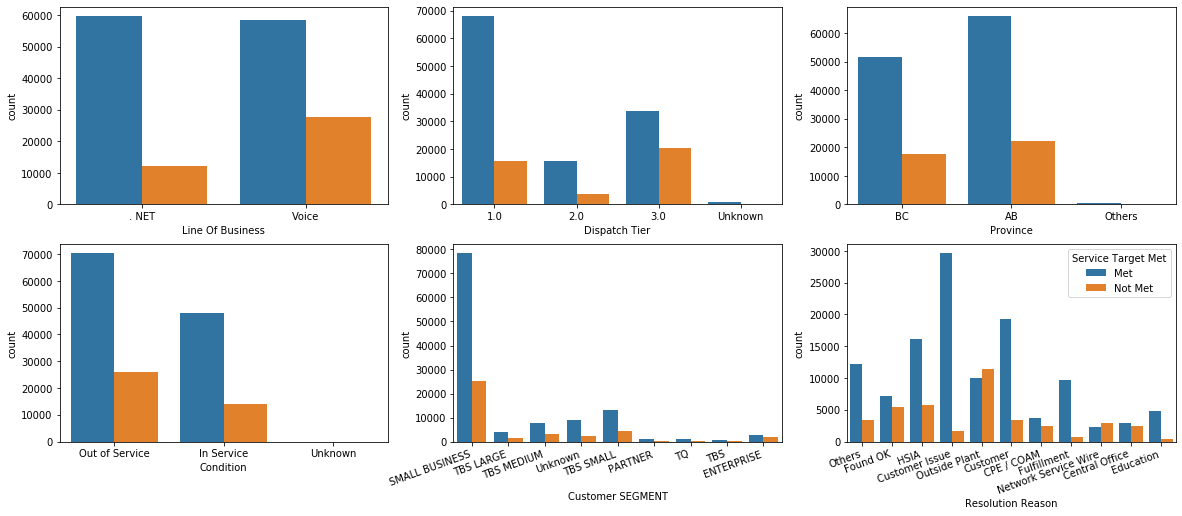

In [84]:
# Service Performance under Each Category: (Counts)

fig, axs = plt.subplots(nrows=2,ncols=3, figsize=(20,8))
ax1 = sns.countplot(x="Line Of Business",hue="Service Target Met", data=Combined,ax=axs[0,0])
ax2= sns.countplot(x="Customer SEGMENT",hue="Service Target Met", data=Combined, ax=axs[1,1])
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=20, ha='right')
ax3 = sns.countplot(x="Province",hue="Service Target Met", data=Combined, ax=axs[0,2])
ax4 = sns.countplot(x="Condition",hue="Service Target Met", data=Combined, ax=axs[1,0])
ax5 = sns.countplot(x="Dispatch Tier",hue="Service Target Met", data=Combined, ax=axs[0,1], order=[1.0, 2.0, 3.0, 'Unknown'])
ax6 = sns.countplot(x="Resolution Reason",hue="Service Target Met", data=Combined, ax=axs[1,2])
ax6.set_xticklabels(ax6.get_xticklabels(),rotation=20, ha='right')

ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()
ax5.get_legend().remove()



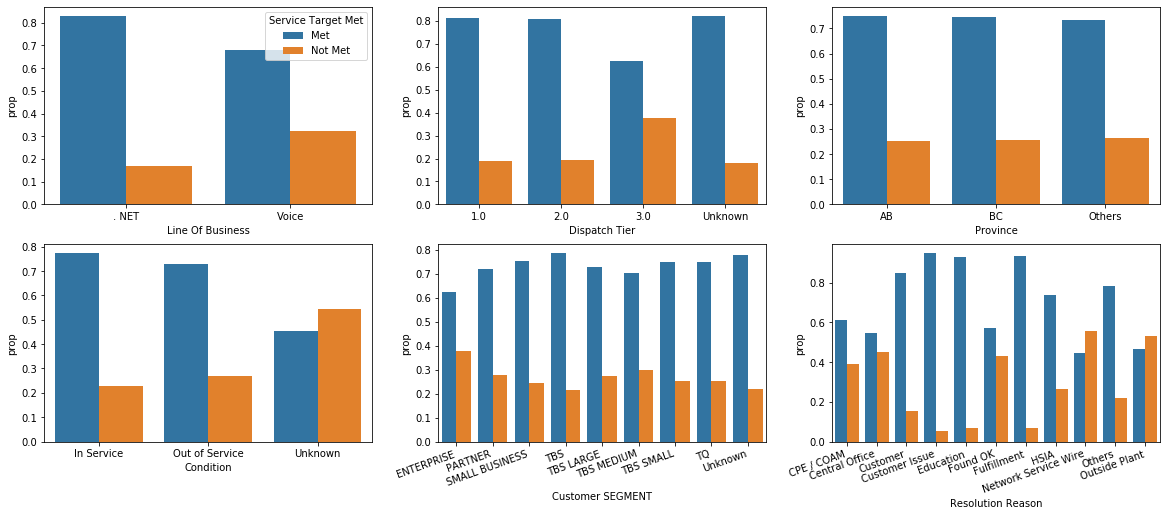

In [83]:
# Service Performance under Each Category: (Percentage)

fig, axs = plt.subplots(nrows=2,ncols=3, figsize=(20,8))
x, y, hue = "Line Of Business", "prop", "Service Target Met"
prop_df = (Combined[hue].groupby(Combined[x]).value_counts(normalize=True).rename(y).reset_index())
ax1=sns.barplot(x=x, y=y, hue=hue, data=prop_df,ax=axs[0,0])
x="Customer SEGMENT"
prop_df = (Combined[hue].groupby(Combined[x]).value_counts(normalize=True).rename(y).reset_index())
ax2=sns.barplot(x=x, y=y, hue=hue, data=prop_df,ax=axs[1,1])
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=20, ha='right')
x="Province"
prop_df = (Combined[hue].groupby(Combined[x]).value_counts(normalize=True).rename(y).reset_index())
ax3=sns.barplot(x=x, y=y, hue=hue, data=prop_df,ax=axs[0,2])
x="Condition"
prop_df = (Combined[hue].groupby(Combined[x]).value_counts(normalize=True).rename(y).reset_index())
ax4=sns.barplot(x=x, y=y, hue=hue, data=prop_df,ax=axs[1,0])
x="Dispatch Tier"
prop_df = (Combined[hue].groupby(Combined[x]).value_counts(normalize=True).rename(y).reset_index())
ax5=sns.barplot(x=x, y=y, hue=hue, data=prop_df,ax=axs[0,1], order=[1.0, 2.0, 3.0, 'Unknown'])
x="Resolution Reason"
prop_df = (Combined[hue].groupby(Combined[x]).value_counts(normalize=True).rename(y).reset_index())
ax6=sns.barplot(x=x, y=y, hue=hue, data=prop_df,ax=axs[1,2])
ax6.set_xticklabels(ax6.get_xticklabels(),rotation=20, ha='right')


#ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()
ax5.get_legend().remove()
ax6.get_legend().remove()


### Service Target Performance under Each Category: (Surveyed Clients with Good/Poor ratings)

In [47]:
# Surveyed clients with Good/Poor ratings
Surveyed_Only=Combined.loc[Combined['Experience'].isin(['Good','Poor'])]
Surveyed_Only.shape

(6406, 19)

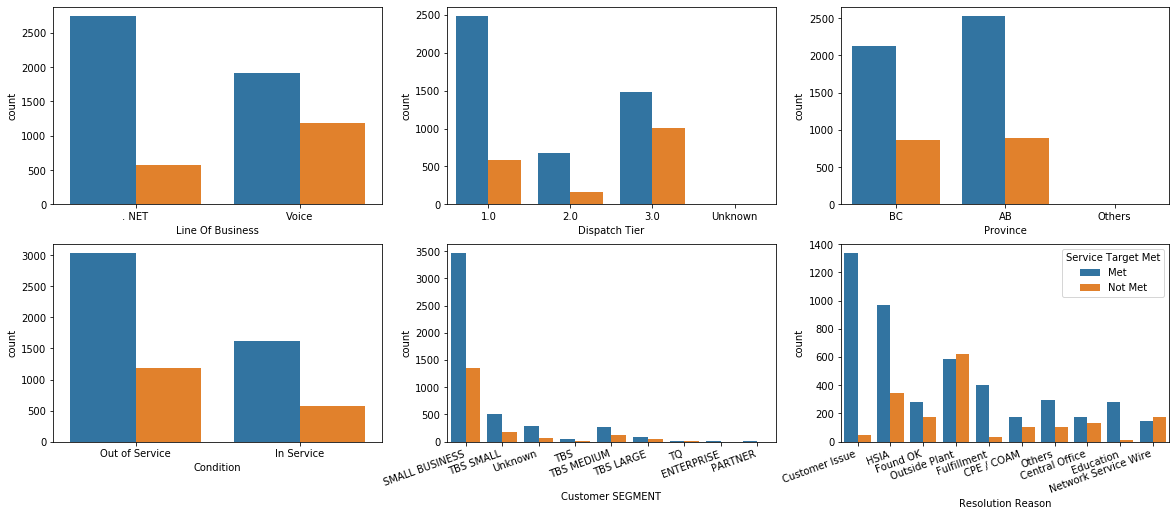

In [82]:
# Service Performance under Each Category: (Counts)

fig, axs = plt.subplots(nrows=2,ncols=3, figsize=(20,8))
ax1 = sns.countplot(x="Line Of Business",hue="Service Target Met", data=Surveyed_Only,ax=axs[0,0])
ax2= sns.countplot(x="Customer SEGMENT",hue="Service Target Met", data=Surveyed_Only, ax=axs[1,1])
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=20, ha='right')
ax3 = sns.countplot(x="Province",hue="Service Target Met", data=Surveyed_Only, ax=axs[0,2])
ax4 = sns.countplot(x="Condition",hue="Service Target Met", data=Surveyed_Only, ax=axs[1,0])
ax5 = sns.countplot(x="Dispatch Tier",hue="Service Target Met", data=Surveyed_Only, ax=axs[0,1], order=[1.0, 2.0, 3.0, 'Unknown'])
ax6 = sns.countplot(x="Resolution Reason",hue="Service Target Met", data=Surveyed_Only, ax=axs[1,2])
ax6.set_xticklabels(ax6.get_xticklabels(),rotation=20, ha='right')

ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()
ax5.get_legend().remove()



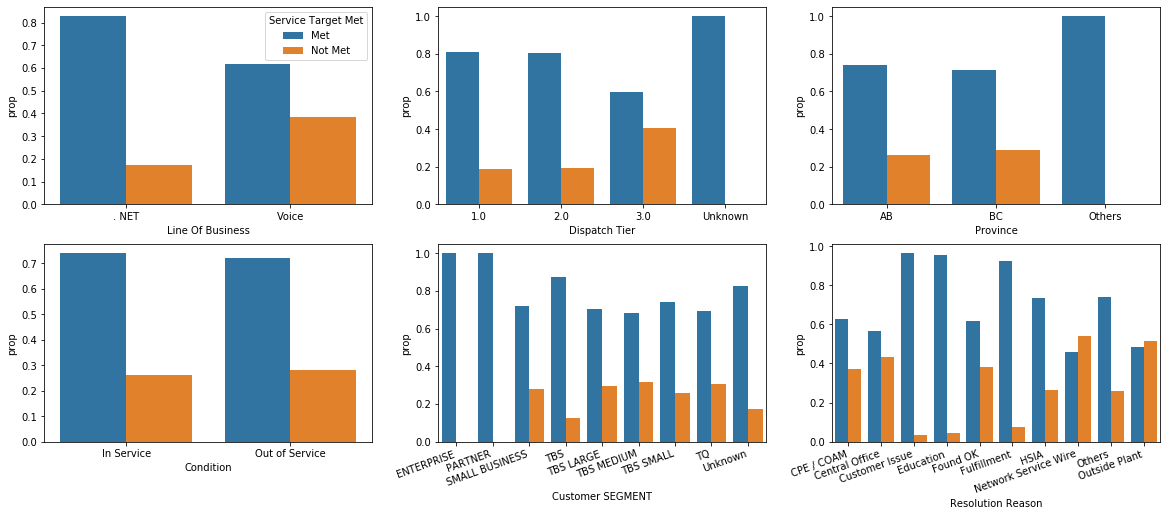

In [81]:
# Service Performance under Each Category: (Percentage)

fig, axs = plt.subplots(nrows=2,ncols=3, figsize=(20,8))
x, y, hue = "Line Of Business", "prop", "Service Target Met"
prop_df = (Surveyed_Only[hue].groupby(Surveyed_Only[x]).value_counts(normalize=True).rename(y).reset_index())
ax1=sns.barplot(x=x, y=y, hue=hue, data=prop_df,ax=axs[0,0])
x="Customer SEGMENT"
prop_df = (Surveyed_Only[hue].groupby(Surveyed_Only[x]).value_counts(normalize=True).rename(y).reset_index())
ax2=sns.barplot(x=x, y=y, hue=hue, data=prop_df,ax=axs[1,1])
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=20, ha='right')
x="Province"
prop_df = (Surveyed_Only[hue].groupby(Surveyed_Only[x]).value_counts(normalize=True).rename(y).reset_index())
ax3=sns.barplot(x=x, y=y, hue=hue, data=prop_df,ax=axs[0,2])
x="Condition"
prop_df = (Surveyed_Only[hue].groupby(Surveyed_Only[x]).value_counts(normalize=True).rename(y).reset_index())
ax4=sns.barplot(x=x, y=y, hue=hue, data=prop_df,ax=axs[1,0])
x="Dispatch Tier"
prop_df = (Surveyed_Only[hue].groupby(Surveyed_Only[x]).value_counts(normalize=True).rename(y).reset_index())
ax5=sns.barplot(x=x, y=y, hue=hue, data=prop_df,ax=axs[0,1], order=[1.0, 2.0, 3.0, 'Unknown'])
x="Resolution Reason"
prop_df = (Surveyed_Only[hue].groupby(Surveyed_Only[x]).value_counts(normalize=True).rename(y).reset_index())
ax6=sns.barplot(x=x, y=y, hue=hue, data=prop_df,ax=axs[1,2])
ax6.set_xticklabels(ax6.get_xticklabels(),rotation=20, ha='right')

#ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()
ax5.get_legend().remove()
ax6.get_legend().remove()


### Service Rating under Each Category: (Surveyed Clients with Good/Poor ratings)

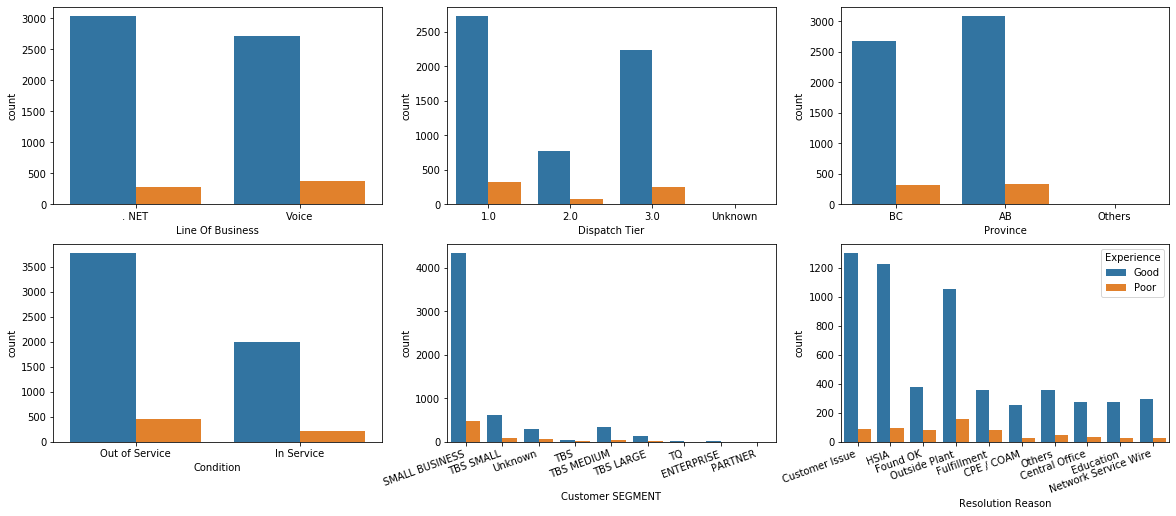

In [79]:
# Service Rating under Each Category: (Counts)

fig, axs = plt.subplots(nrows=2,ncols=3, figsize=(20,8))
ax1 = sns.countplot(x="Line Of Business",hue="Experience", data=Surveyed_Only,ax=axs[0,0])
ax2= sns.countplot(x="Customer SEGMENT",hue="Experience", data=Surveyed_Only, ax=axs[1,1])
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=20, ha='right')
ax3 = sns.countplot(x="Province",hue="Experience", data=Surveyed_Only, ax=axs[0,2])
ax4 = sns.countplot(x="Condition",hue="Experience", data=Surveyed_Only, ax=axs[1,0])
ax5 = sns.countplot(x="Dispatch Tier",hue="Experience", data=Surveyed_Only, ax=axs[0,1], order=[1.0, 2.0, 3.0, 'Unknown'])
ax6 = sns.countplot(x="Resolution Reason",hue="Experience", data=Surveyed_Only, ax=axs[1,2])
ax6.set_xticklabels(ax6.get_xticklabels(),rotation=20, ha='right')

ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()
ax5.get_legend().remove()

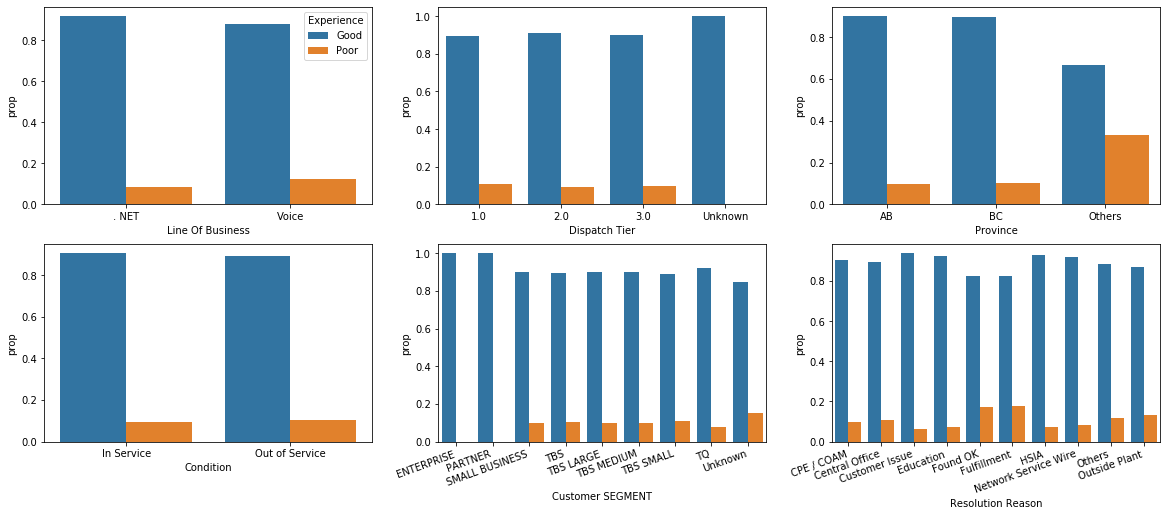

In [80]:
# Service Rating under Each Category: (Percentage)

fig, axs = plt.subplots(nrows=2,ncols=3, figsize=(20,8))

x, y, hue = "Line Of Business", "prop", "Experience"
prop_df = (Surveyed_Only[hue].groupby(Surveyed_Only[x]).value_counts(normalize=True).rename(y).reset_index())
ax1=sns.barplot(x=x, y=y, hue=hue, data=prop_df,ax=axs[0,0])
x="Customer SEGMENT"
prop_df = (Surveyed_Only[hue].groupby(Surveyed_Only[x]).value_counts(normalize=True).rename(y).reset_index())
ax2=sns.barplot(x=x, y=y, hue=hue, data=prop_df,ax=axs[1,1])
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=20, ha='right')
x="Province"
prop_df = (Surveyed_Only[hue].groupby(Surveyed_Only[x]).value_counts(normalize=True).rename(y).reset_index())
ax3=sns.barplot(x=x, y=y, hue=hue, data=prop_df,ax=axs[0,2])
x="Condition"
prop_df = (Surveyed_Only[hue].groupby(Surveyed_Only[x]).value_counts(normalize=True).rename(y).reset_index())
ax4=sns.barplot(x=x, y=y, hue=hue, data=prop_df,ax=axs[1,0])
x="Dispatch Tier"
prop_df = (Surveyed_Only[hue].groupby(Surveyed_Only[x]).value_counts(normalize=True).rename(y).reset_index())
ax5=sns.barplot(x=x, y=y, hue=hue, data=prop_df,ax=axs[0,1], order=[1.0, 2.0, 3.0, 'Unknown'])
x="Resolution Reason"
prop_df = (Surveyed_Only[hue].groupby(Surveyed_Only[x]).value_counts(normalize=True).rename(y).reset_index())
ax6=sns.barplot(x=x, y=y, hue=hue, data=prop_df,ax=axs[1,2])
ax6.set_xticklabels(ax6.get_xticklabels(),rotation=20, ha='right')


#ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()
ax5.get_legend().remove()
ax6.get_legend().remove()

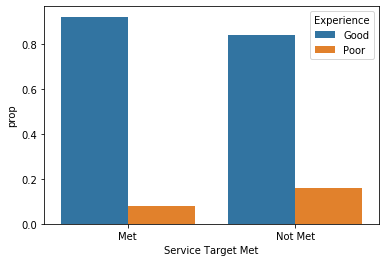

In [34]:
# Service Rating by Service Target:

x="Service Target Met"
prop_df = (Surveyed_Only[hue].groupby(Surveyed_Only[x]).value_counts(normalize=True).rename(y).reset_index())
sns.barplot(x=x, y=y, hue=hue, data=prop_df)#.get_legend().remove()


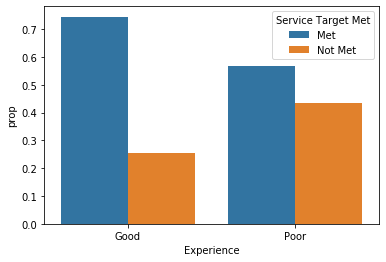

In [35]:
# Service Target by Service Rating:

x,hue="Experience","Service Target Met"
prop_df = (Surveyed_Only[hue].groupby(Surveyed_Only[x]).value_counts(normalize=True).rename(y).reset_index())
sns.barplot(x=x, y=y, hue=hue, data=prop_df)#.get_legend().remove()


### Model Exploreation and Feature Importance:

In [45]:
Surveyed_Only['Experience'].value_counts()

#Two Customer Experience classes are highly imbalanced (9:1)

Good    5755
Poor     651
Name: Experience, dtype: int64

In [49]:
target=Surveyed_Only['Experience']
features=Surveyed_Only.drop(['Customer Experience Score','Experience','Ticket Number','Ticket Create Date', 'Ticket Create Time', 'Ticket Closed Date','Ticket Closed Time', 'Ticket Resolution Date','Ticket Resolution Time', 'City', 'RESOLUTION_CODE'  ], axis=1)
feature_Encoded=pd.get_dummies(features)
x_train,x_test,y_train,y_test = train_test_split(feature_Encoded,target, stratify=target,test_size=0.35, random_state=1)

In [52]:
feature_Encoded.shape

(6406, 33)

In [74]:
# Balanced Random Forest Model
from imblearn.ensemble import BalancedRandomForestClassifier
forest = BalancedRandomForestClassifier(n_estimators=150, random_state=2)
forest.fit(x_train, y_train)
forest_predict=forest.predict(x_test)

print(classification_report(y_test, forest_predict))

#Feature importances - top Five influential features:
score=forest.feature_importances_
name=list(x_train)
name_array=np.asarray(name)
combine=pd.DataFrame([name_array, score]).T
combine.columns=('Name', 'Score')

print(combine.sort_values('Score', ascending=0).head(10))

              precision    recall  f1-score   support

        Good       0.94      0.64      0.76      2015
        Poor       0.17      0.65      0.27       228

    accuracy                           0.64      2243
   macro avg       0.55      0.64      0.51      2243
weighted avg       0.86      0.64      0.71      2243

                               Name      Score
0             Time To Restore (Hrs)   0.285837
17                Dispatch Tier_1.0   0.043807
19                Dispatch Tier_3.0  0.0390494
32       Service Target Met_Not Met  0.0386984
15             Condition_In Service   0.038553
12                      Province_AB  0.0380941
16         Condition_Out of Service  0.0369693
5   Customer SEGMENT_SMALL BUSINESS  0.0364838
31           Service Target Met_Met  0.0350625
30  Resolution Reason_Outside Plant   0.034655


In [61]:
# peek on a sampled tree
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()

estimator = forest.estimators_[1] # tree #28
target=y_test.astype(str).unique()

#output the graph spec into a dot file
from sklearn.tree import export_graphviz
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = list(x_test.columns),
                 max_depth=5,
                class_names = target,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

(0, 100)

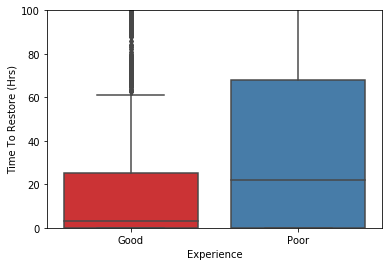

In [64]:
sns.boxplot(x='Experience', y='Time To Restore (Hrs)', data=Surveyed_Only, palette="Set1")
plt.ylim(0, 100)

In [71]:
Good_Median=Surveyed_Only.loc[Surveyed_Only['Experience']=='Good'] ['Time To Restore (Hrs)'].median()
Poor_Median=Surveyed_Only.loc[Surveyed_Only['Experience']=='Poor'] ['Time To Restore (Hrs)'].median()
print(Good_Median, Poor_Median)

3.0 22.0


In [75]:
Good_Mean=Surveyed_Only.loc[Surveyed_Only['Experience']=='Good'] ['Time To Restore (Hrs)'].mean()
Poor_Mean=Surveyed_Only.loc[Surveyed_Only['Experience']=='Poor'] ['Time To Restore (Hrs)'].mean()
print(Good_Mean, Poor_Mean)

27.068983492615118 69.92626728110599


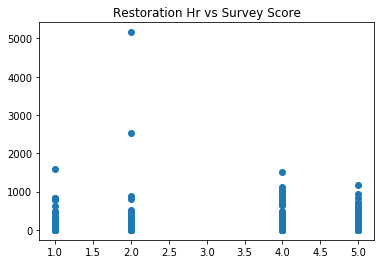

In [89]:
plt.scatter(Surveyed_Only['Customer Experience Score'],Surveyed_Only['Time To Restore (Hrs)'])
plt.title('Restoration Hr vs Survey Score')
plt.show()

# Not clear on the trend by directly observting this plot